<a href="https://colab.research.google.com/github/EricChan12311/DMA/blob/main/DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import urllib.request

In [5]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [2]:
# Load dataset.csv into the notebook.
data = pd.read_csv("dataset.csv")

In [3]:
data.head()

,ID,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,54:00.0,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1
1,21:31.0,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1
2,18:00.0,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1
3,43:00.0,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5
4,57:17.0,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2


### **Percentage of Missing Values (By David Tan Chow Meng)**

In [4]:
data.isnull().sum()

ID                 0
travel_fee         0
departure_time     0
departure_long     0
departure_lat      0
arrival_long      14
arrival_lat       14
occupancy          0
dtype: int64

In [5]:
missing_values_count = data.isnull().sum()
total_rows = data.shape[0]
missing_values_percentage = (missing_values_count / total_rows) * 100

In [6]:
# Create a DataFrame to display missing values count and percentage
missing_data = pd.DataFrame({
    'Missing Values Count': missing_values_count,
    'Percentage Missing': missing_values_percentage
})

# Display the missing data information
print
(missing_data)


,Missing Values Count,Percentage Missing
ID,0,0.000000
travel_fee,0,0.000000
departure_time,0,0.000000
departure_long,0,0.000000
departure_lat,0,0.000000
arrival_long,14,0.001335
arrival_lat,14,0.001335
occupancy,0,0.000000


# Split dataset into train set and test set


In [7]:
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

print("Length of train_set:", len(train_set))
print("Length of test_set:", len(test_set))

Length of train_set: 838860
Length of test_set: 209715


# Visualization of the Dataset (Done By: Chan Heng Hung)

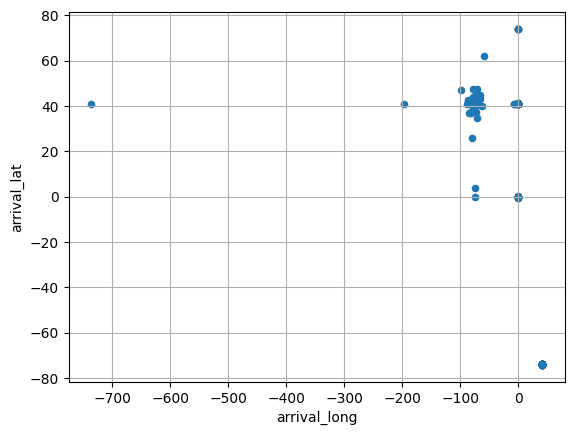

In [8]:
train_set.plot(kind="scatter", x="arrival_long", y="arrival_lat", grid=True)
plt.show()

Text(0, 0.5, 'Count')

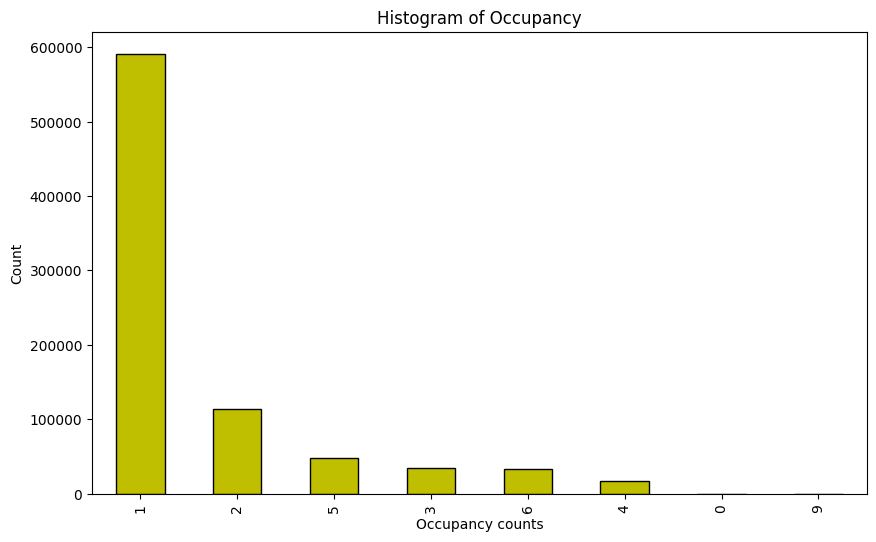

In [9]:
import seaborn as sns
plt.figure(figsize=(10,6))
train_set['occupancy'].value_counts().plot.bar(color = 'y', edgecolor = 'k');
plt.title('Histogram of Occupancy')
plt.xlabel('Occupancy counts')
plt.ylabel('Count')

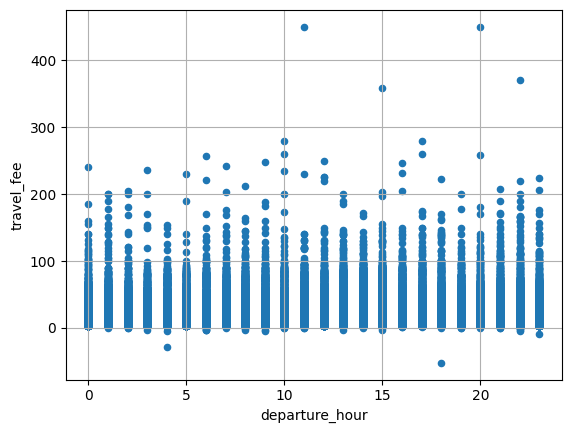

In [15]:
train_set['departure_time'] = pd.to_datetime(train_set['departure_time'])
train_set['departure_hour'] = train_set['departure_time'].dt.hour
train_set.plot(kind="scatter", x="departure_hour", y="travel_fee", grid=True)
plt.show()

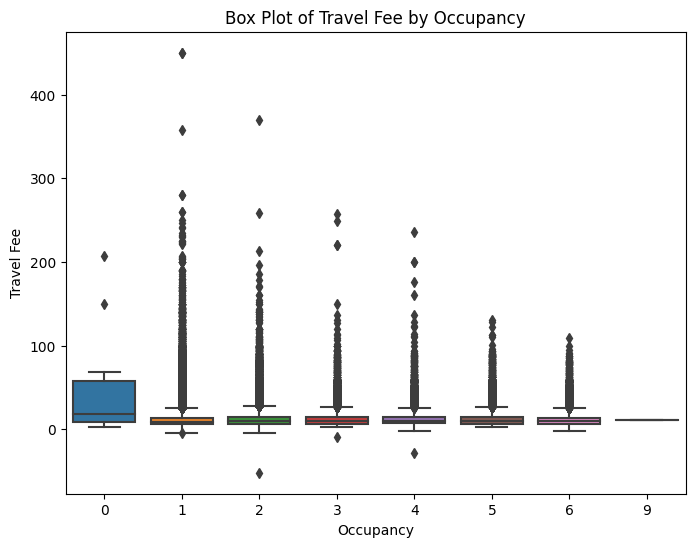

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='occupancy', y='travel_fee', data=train_set)
plt.xlabel('Occupancy')
plt.ylabel('Travel Fee')
plt.title('Box Plot of Travel Fee by Occupancy')
plt.show()

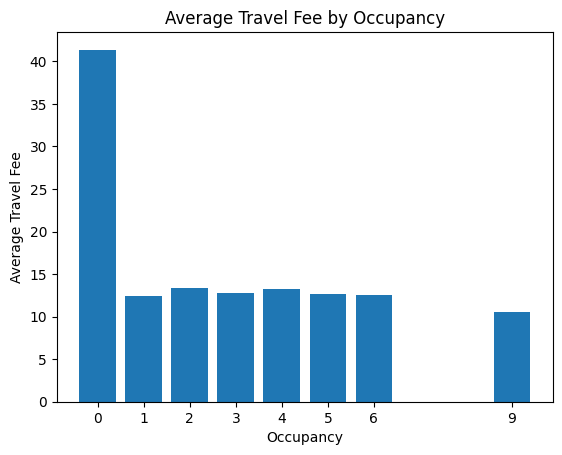

In [13]:
average_fare_by_occupancy = train_set.groupby('occupancy')['travel_fee'].mean()

plt.bar(average_fare_by_occupancy.index, average_fare_by_occupancy.values)
plt.xlabel('Occupancy')
plt.ylabel('Average Travel Fee')
plt.title('Average Travel Fee by Occupancy')
plt.xticks(average_fare_by_occupancy.index)
plt.show()

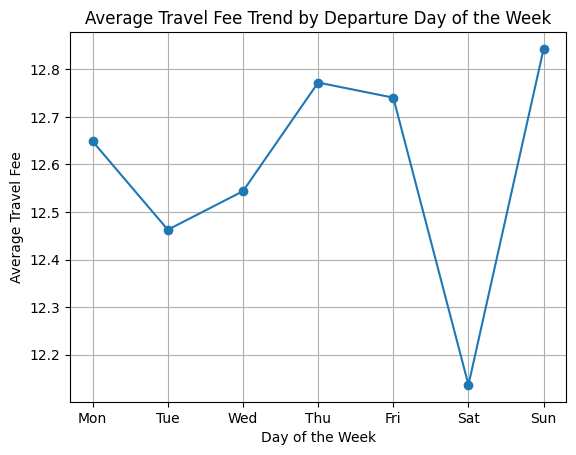

In [17]:
train_set['day_of_week'] = train_set['departure_time'].dt.dayofweek
average_fare_by_dow = train_set.groupby('day_of_week')['travel_fee'].mean()

plt.plot(average_fare_by_dow.index, average_fare_by_dow.values, marker='o')
plt.xlabel('Day of the Week')
plt.ylabel('Average Travel Fee')
plt.title('Average Travel Fee Trend by Departure Day of the Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid()
plt.show()

# Correlation Between Attributes (Done By: Eason Chuah)




In [ ]:
corr_matrix = train_set.corr(numeric_only=True)
corr_matrix["travel_fee"].sort_values(ascending=False)

travel_fee        1.000000
arrival_long      0.019548
departure_long    0.017826
occupancy         0.011196
day_of_week       0.000309
departure_lat    -0.014545
arrival_lat      -0.016039
departure_hour   -0.018889
Name: travel_fee, dtype: float64

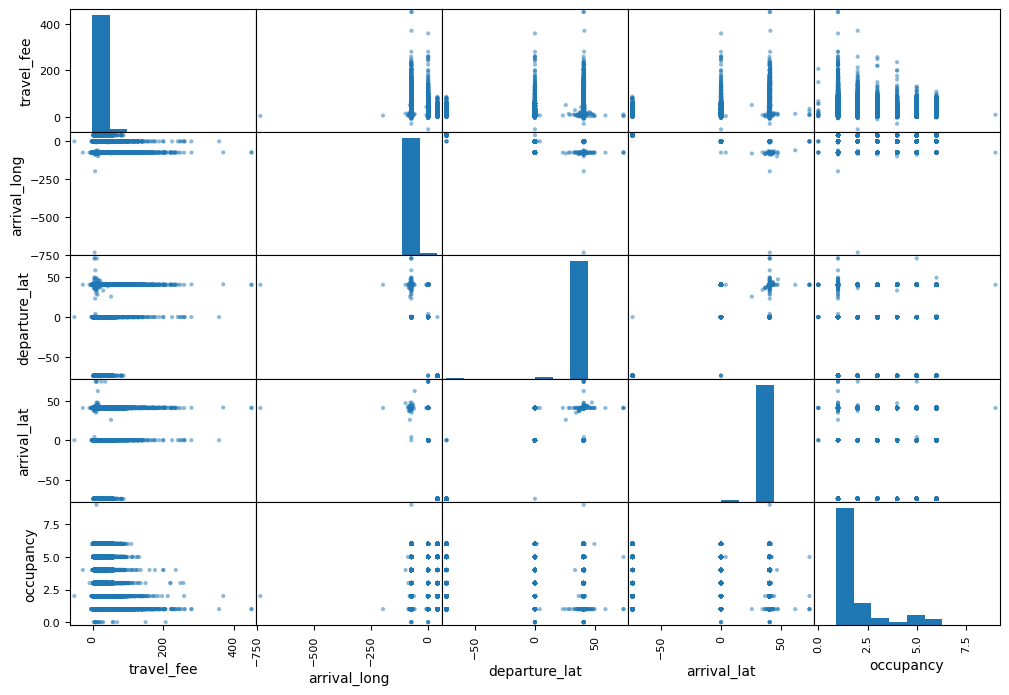

In [18]:
from pandas.plotting import scatter_matrix

attributes = ["travel_fee", "arrival_long","departure_lat","arrival_lat","departure_hour"]
scatter_matrix(train_set[attributes], figsize=(12, 8))
plt.show()

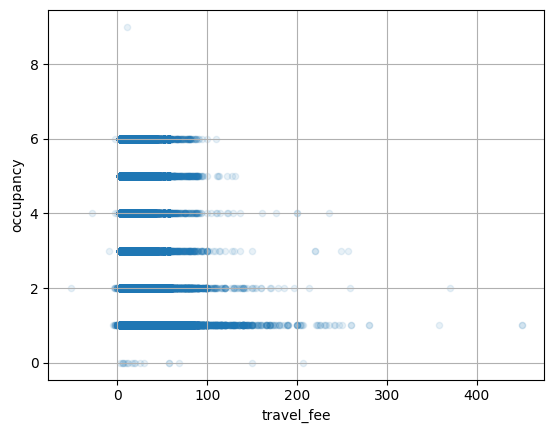

In [ ]:
train_set.plot(kind="scatter", x="travel_fee", y="occupancy", alpha=0.1, grid=True)
plt.show()

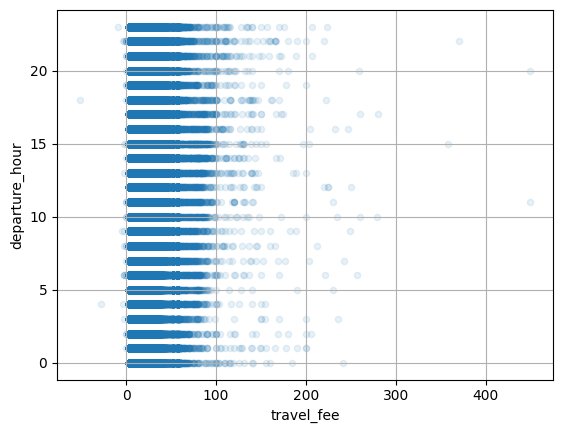

In [ ]:
train_set.plot(kind="scatter", x="travel_fee", y="departure_hour", alpha=0.1, grid=True)
plt.show()

#Query data in data frame

In [ ]:
import numpy as np

# Calculate distance
R = 6371
lat1, lon1, lat2, lon2 = map(np.radians, [train_set['departure_lat'], train_set['departure_long'], train_set['arrival_lat'], train_set['arrival_long']])
dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
train_set['distance'] = R * c

train_set['price_per_km'] = train_set['travel_fee'] / train_set['distance']
train_set['departure_time'] = pd.to_datetime(train_set['departure_time'])


In [ ]:
# 1. Month vs Price per km

train_set['month'] = train_set['departure_time'].dt.month

custom_bins = [-np.inf, 0, 10, 20, 30, 40, 50, 75, 100, np.inf]
pd.crosstab(index=train_set['month'], columns=pd.cut(train_set['price_per_km'], custom_bins), margins=True)

price_per_km,"(-inf, 0.0]","(0.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 75.0]","(75.0, 100.0]","(100.0, inf]",All
month,,,,,,,,,,
1,0,67089,1664,179,76,39,80,42,2285,71454
2,0,63913,1712,184,71,47,63,47,2243,68280
3,0,71857,1846,206,83,37,65,42,2314,76450
4,0,69376,1627,177,84,38,56,39,2120,73517
5,0,69029,2179,286,102,40,73,40,2157,73906
6,0,65424,1820,181,77,39,60,26,1918,69545
7,0,63796,1703,183,75,40,78,34,1668,67577
8,24,57480,1359,174,77,35,49,28,1325,60551
9,0,64196,1676,191,69,51,63,37,1434,67717


In [ ]:
# 2. Day vs price_per_km (weekend and weekday)

train_set['day_of_week'] = train_set['departure_time'].dt.dayofweek
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train_set['day_name'] = train_set['day_of_week'].map(lambda x: day_names[x])

custom_bins = [-np.inf, 0, 10, 20, 30, 40, 50, 75, 100, np.inf]
(pd.crosstab(index=train_set['day_name'], columns=pd.cut(train_set['price_per_km'], custom_bins), margins=True)
                  .loc[day_names])

price_per_km,"(-inf, 0.0]","(0.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 75.0]","(75.0, 100.0]","(100.0, inf]",All
day_name,,,,,,,,,,
Monday,2,102253,2531,258,123,75,84,67,2956,108349
Tuesday,5,111691,3058,342,138,65,118,53,3339,118809
Wednesday,1,113599,3498,342,150,62,98,58,3171,120979
Thursday,4,116732,3603,403,157,89,112,59,3404,124563
Friday,6,119625,3560,405,139,100,133,82,3561,127611
Saturday,4,119981,2846,343,164,79,130,66,3434,127047
Sunday,2,105617,2227,294,115,64,106,56,3000,111481


In [ ]:
# 3. weekend and weekday vs price_per_km

train_set['day_type'] = train_set['departure_time'].apply(lambda x: 'Weekend' if x.weekday() >= 5 else 'Weekday')


custom_bins = [-np.inf, 0, 10, 20, 30, 40, 50, 75, 100, np.inf]
pd.crosstab(index=train_set['day_type'], columns=pd.cut(train_set['price_per_km'], custom_bins), margins=True)


price_per_km,"(-inf, 0.0]","(0.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 75.0]","(75.0, 100.0]","(100.0, inf]",All
day_type,,,,,,,,,,
Weekday,18,563900,16250,1750,707,391,545,319,16431,600311
Weekend,6,225598,5073,637,279,143,236,122,6434,238528
All,24,789498,21323,2387,986,534,781,441,22865,838839


In [ ]:
# 4. Period vs price_per_km

def return_period(hour):
    if 4 <= hour < 6:
        return 'Early Morning'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 20:
        return 'Evening'
    elif 20 <= hour < 24:
        return 'Night'
    else:
        return 'Midnight'

train_set['period_hour'] = train_set['departure_time'].dt.hour.apply(return_period)

custom_bins = [-np.inf, 0, 10, 20, 30, 40, 50, 75, 100, np.inf]
desired_order = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Midnight']

(pd.crosstab(index=train_set['period_hour'], columns=pd.cut(train_set['price_per_km'], custom_bins), margins=True)
    .reindex(desired_order))

price_per_km,"(-inf, 0.0]","(0.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 75.0]","(75.0, 100.0]","(100.0, inf]",All
period_hour,,,,,,,,,,
Early Morning,2,17317,258,41,25,18,22,14,602,18299
Morning,11,189727,5411,557,254,105,181,110,5505,201861
Afternoon,1,182689,6916,730,256,148,203,118,5506,196567
Evening,2,135371,3794,413,168,80,132,65,3796,143821
Night,6,178922,3245,400,176,113,142,67,4830,187901
Midnight,2,85472,1699,246,107,70,101,67,2626,90390


In [ ]:
# 5.  Peak hour vs price_per_km (can know the peak hour)

train_set['hour'] = train_set['departure_time'].dt.hour
custom_bins = [-np.inf, 0, 10, 20, 30, 40, 50, 75, 100, np.inf]
pd.crosstab(index=train_set['hour'], columns=pd.cut(train_set['price_per_km'], custom_bins), margins=True)

price_per_km,"(-inf, 0.0]","(0.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 75.0]","(75.0, 100.0]","(100.0, inf]",All
hour,,,,,,,,,,
0,0,31906,589,74,34,22,39,18,897,33579
1,1,23465,463,69,29,18,24,17,716,24802
2,1,17496,365,58,20,15,21,17,566,18559
3,0,12605,282,45,24,15,17,15,447,13450
4,2,9265,176,29,15,12,16,6,337,9858
5,0,8052,82,12,10,6,6,8,265,8441
6,3,16390,165,33,20,10,11,14,505,17151
7,1,28839,449,66,32,13,26,18,871,30315
8,3,36111,973,117,48,18,39,21,1044,38374


In [ ]:
# 6. Occupancy vs price_per_km

custom_bins = [-np.inf, 0, 10, 20, 30, 40, 50, 75, 100, np.inf]
pd.crosstab(index=train_set['occupancy'], columns=pd.cut(train_set['price_per_km'], custom_bins), margins=True)


price_per_km,"(-inf, 0.0]","(0.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 75.0]","(75.0, 100.0]","(100.0, inf]",All
occupancy,,,,,,,,,,
0,0,0,0,0,0,0,0,0,7,7
1,15,555639,14671,1632,691,389,557,319,16979,590892
2,5,107149,2949,331,133,68,94,54,2750,113533
3,1,33393,920,101,36,19,32,15,835,35352
4,3,16493,484,57,15,9,17,12,445,17535
5,0,45908,1391,151,71,24,49,29,1100,48723
6,0,30915,908,115,40,25,32,12,749,32796
9,0,1,0,0,0,0,0,0,0,1
All,24,789498,21323,2387,986,534,781,441,22865,838839


# Data Preprocessing(Done By:Foo Shao Lun)

# 1. Data Cleaning

# Drop rows of 'travel_fee' with negative value

In [ ]:
train_set = train_set[train_set["travel_fee"] > 0]

# Handle Outliers using IQR

In [ ]:
# Handle outliers using IQR
Q1 = train_set['travel_fee'].quantile(0.25)
Q3 = train_set['travel_fee'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
train_set = train_set[(train_set['travel_fee'] >= lower_bound)&(train_set['travel_fee'] <= upper_bound)]

In [ ]:
train_subset, validation_subset = train_test_split(train_set, test_size=0.8, random_state=42)

In [ ]:
data = train_subset.drop("travel_fee", axis=1) #Input Feeatures
data_labels = train_subset["travel_fee"].copy() #Output Feature

# 2. Handle Text Features

In [ ]:
# Drop the 'ID' column
data.drop(columns=['ID'], inplace=True)

In [ ]:
# Convert 'departure_time' to datetime format and extract components
data['departure_time'] = pd.to_datetime(data['departure_time'])
data['hour'] = data['departure_time'].dt.hour
data['day_of_week'] = data['departure_time'].dt.dayofweek
data['month'] = data['departure_time'].dt.month
data.drop(columns=['departure_time'], inplace=True)

# Determine if the travel is during the weekend
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Categorize the hour into parts of the day
bins = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'afternoon', 'evening']
data['part_of_day'] = pd.cut(data['hour'], bins=bins, labels=labels, right=False)

# 3. Feature Engineering

In [ ]:
# Calculate distance traveled using Haversine formula
# Radius of the Earth
R = 6371
lat1, lon1, lat2, lon2 = map(np.radians, [data['departure_lat'], data['departure_long'], data['arrival_lat'], data['arrival_long']])
dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
data['distance_traveled'] = R * c

# 4. Feature Encoding and Scaling

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Columns to scale and encode
num_attribs = ['departure_long', 'departure_lat', 'arrival_long', 'arrival_lat', 'occupancy', 'hour', 'day_of_week', 'month', 'distance_traveled']
cat_attribs = ['part_of_day']

# Numerical pipeline
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), #data cleaning
    # you may add log transformation if needed
    StandardScaler() #feature scaling
)

# Categorical pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), #most_frequent=mode #data cleaning
    OneHotEncoder(handle_unknown="ignore") #feature scaling
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),])

# Applying the preprocessing to the data
data_prepared = preprocessing.fit_transform(data)
data_prepared

array([[-0.13373492,  0.1267019 , -0.13919739, ...,  0.        ,
         0.        ,  0.        ],
       [-0.13819429,  0.11926305, -0.13878815, ...,  1.        ,
         0.        ,  0.        ],
       [-0.13679914,  0.12264109, -0.14039549, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.13846035,  0.1207518 , -0.13740435, ...,  1.        ,
         0.        ,  0.        ],
       [-0.13694848,  0.12278453, -0.13777148, ...,  1.        ,
         0.        ,  0.        ],
       [-0.13287991,  0.12938981, -0.13791826, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
preprocessing.get_feature_names_out()

array(['num__departure_long', 'num__departure_lat', 'num__arrival_long',
       'num__arrival_lat', 'num__occupancy', 'num__hour',
       'num__day_of_week', 'num__month', 'num__distance_traveled',
       'cat__part_of_day_afternoon', 'cat__part_of_day_evening',
       'cat__part_of_day_morning', 'cat__part_of_day_night'], dtype=object)

# Modeling(Done by: Chan Heng Hung, Eason Chuah Chung Chin, .............)


## RandomForest (Done by: Chan Heng Hung)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict

forest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)

forest_rmses = -cross_val_score(forest_reg, data, data_labels,
                                scoring="neg_root_mean_squared_error",
                                cv=3)
forest_rmses

array([2.23940108, 2.26626485, 2.27473585])

In [ ]:
pd.Series(forest_rmses).describe()

count    3.000000
mean     2.260134
std      0.018448
min      2.239401
25%      2.252833
50%      2.266265
75%      2.270500
max      2.274736
dtype: float64

In [ ]:
from sklearn.model_selection import cross_validate
forest_rmses = cross_validate(forest_reg,
                              data, data_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=2,
                              return_train_score=True)

forest_rmses

{'fit_time': array([67.91798377, 66.08617783]),
 'score_time': array([2.77838802, 2.37478065]),
 'test_score': array([-2.26437419, -2.27887154]),
 'train_score': array([-0.87573795, -0.87568974])}

In [ ]:
forest_reg.fit(data, data_labels)
data_predictions = forest_reg.predict(data)
forest_rmse = mean_squared_error(data_labels,
                                 data_predictions,
                                 squared=False)
forest_rmse

0.878132628893082

# Decision Tree  (Done By: Eason Chuah)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat', 'occupancy',
                                                   'hour', 'day_of_week',
                                                   'month',
                                                   'distance_traveled']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['part_of_day'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
tree_reg.fit(data, data_labels)
data_predictions = tree_reg.predict(data)
tree_rmse = mean_squared_error(data_labels, data_predictions, squared=False)
tree_rmse

0.31523445301197794

In [ ]:
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(tree_reg,
                              data, data_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=10)
tree_rmses

array([3.1609139 , 3.16954208, 3.17145969, 3.17150578, 3.20165462,
       3.16016827, 3.13210757, 3.17537981, 3.26617174, 3.17821518])

In [ ]:
pd.Series(tree_rmses).describe()

count    10.000000
mean      3.178712
std       0.035290
min       3.132108
25%       3.163071
50%       3.171483
75%       3.177506
max       3.266172
dtype: float64

### **Linear Regression (By David Tan Chow Meng)**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

linear_reg = make_pipeline(preprocessing, LinearRegression())
linear_reg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat', 'occupancy',
                                                   'hour', 'day_of_week',
                                                   'month',
                                                   'distance_traveled']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['part_of_day'])])),
                ('linearregression', LinearRegression())])

In [ ]:
linear_reg.fit(data, data_labels)
data_predictions = linear_reg.predict(data)
linear_rmse = mean_squared_error(data_labels, data_predictions, squared=False)
linear_rmse

4.700224035946884

In [ ]:
from sklearn.model_selection import cross_val_score
linear_rmses = -cross_val_score(linear_reg,
                              data, data_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=10)
linear_rmses

array([4.61272214, 4.70020986, 4.72829257, 4.75306139, 4.73785275,
       4.70621923, 4.63905018, 4.68191721, 4.76374974, 4.68132532])

In [ ]:
pd.Series(linear_rmses).describe()

count    10.000000
mean      4.700440
std       0.048486
min       4.612722
25%       4.681473
50%       4.703215
75%       4.735463
max       4.763750
dtype: float64

### **Evaluation (By David Tan Chow Meng)**

In [ ]:
rmse_values = [linear_rmse, tree_rmse, forest_rmse]  # Replace with your actual MSE values

In [ ]:
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest Regression', 'Decision Tree Regression'],
    'RMSE': rmse_values,
})

In [ ]:
print(results_df)

                      Model      RMSE
0         Linear Regression  4.700224
1  Random Forest Regression  0.315234
2  Decision Tree Regression  0.878133


In [ ]:
forest_reg.fit(data, data_labels)
data_predictions = forest_reg.predict(data)
forest_mse = mean_squared_error(data_labels,
                                 data_predictions)
forest_mse

0.7711169139266753

In [ ]:
tree_reg.fit(data, data_labels)
data_predictions = tree_reg.predict(data)
tree_mse = mean_squared_error(data_labels, data_predictions)
tree_mse

0.09937276036576094

In [ ]:
linear_reg.fit(data, data_labels)
data_predictions = linear_reg.predict(data)
linear_mse = mean_squared_error(data_labels, data_predictions)
linear_mse

22.09210598809282

In [ ]:
from sklearn.metrics import r2_score

R2 Score

In [ ]:
forest_reg.fit(data, data_labels)
data_predictions = forest_reg.predict(data)
forest_r2 = r2_score(data_labels,
                     data_predictions)
forest_r2

0.9652854460968717

In [ ]:
tree_reg.fit(data, data_labels)
data_predictions = tree_reg.predict(data)
tree_r2 = r2_score(data_labels, data_predictions)
tree_r2

0.9955263838933924

In [ ]:
linear_reg.fit(data, data_labels)
data_predictions = linear_reg.predict(data)
linear_r2 = r2_score(data_labels, data_predictions)
linear_r2

0.005445749786528009

In [ ]:
mse_values = [linear_mse, tree_mse, forest_mse]  # Replace with your actual MSE values
rmse_values = [linear_rmse, tree_rmse, forest_rmse]
r2_values = [linear_r2, tree_r2, forest_r2]

In [ ]:
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest Regression', 'Decision Tree Regression'],
    'MSE' : mse_values,
    'RMSE': rmse_values,
    'R-squared' : r2_values
})

In [ ]:
print(results_df)

                      Model        MSE      RMSE  R-squared
0         Linear Regression  22.092106  4.700224   0.005446
1  Random Forest Regression   0.099373  0.315234   0.995526
2  Decision Tree Regression   0.771117  0.878133   0.965285
